# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = 'traffic-signs-data/train.p'
validation_file= 'traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration


### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
import numpy as np
# Number of training examples
n_train = X_train.shape[0]

#Number of validation examples
n_validation = X_valid.shape[0]

#Number of testing examples.
n_test = X_test.shape[0]

#What's the shape of an traffic sign image?
image_shape = X_train[0].shape

#How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(np.append(np.append(y_train,y_test,axis=0),y_valid,axis=0)))

print("Number of training examples =", n_train)
print("Number of validating examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validating examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

Total image class in train dataset : 


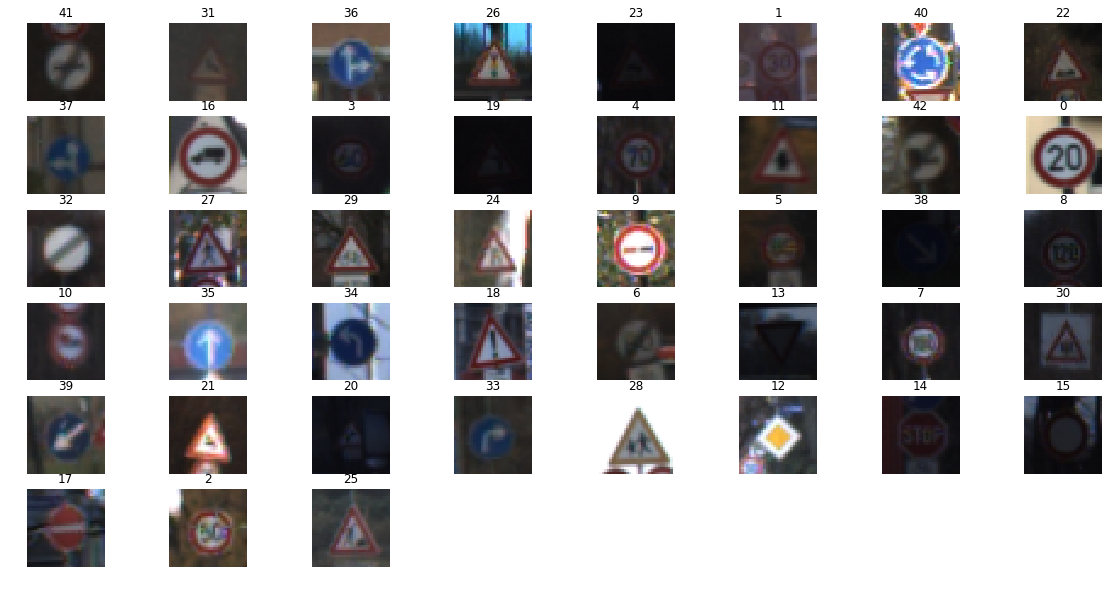

In [3]:
### Data exploration visualization code goes here.
import random
import numpy as np
import matplotlib.pyplot as plt

# Visualizations will be shown in the notebook.
%matplotlib inline
signs = []
caches = []
for index, label in enumerate(y_train):
    if label not in caches:
        caches.append(label)
        signs.append((label, index))

# Show a random collection of the preprocessed images
fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(10)
print("Total image class in train dataset : ")
for index, sign in enumerate(signs):
    ax = fig.add_subplot(6, 8, index + 1)
    ax.axis('off')
    ax.set_title(sign[0])
    image = X_train[sign[1]].squeeze()
    ax.imshow(image)

### Distribution of classes in the training, validation and test set

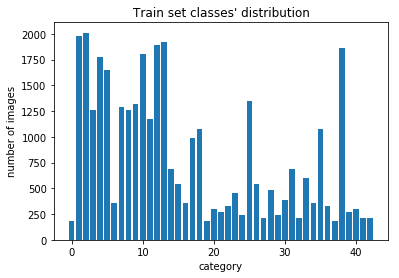

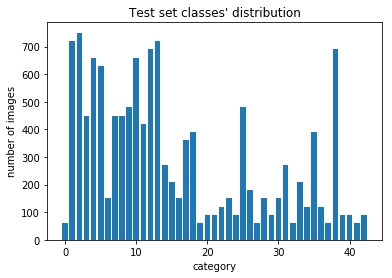

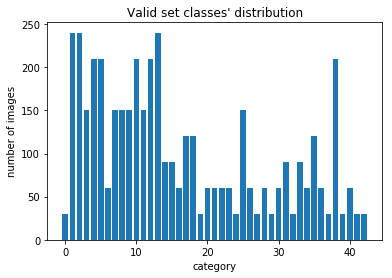

In [4]:
def count_sign(y):
    labels=np.zeros(n_classes)
    for i in range(0,len(y)):
        labels[y[i]] +=1
    return labels
    
y_train_dis= count_sign(y_train)
y_test_dis= count_sign(y_test)
y_valid_dis= count_sign(y_valid)
print("")
import matplotlib.pyplot as plt
plt.title('Train set classes\' distribution')
plt.xlabel('category')
plt.ylabel('number of images')
plt.bar(range(len(y_train_dis)), y_train_dis)
plt.show()

plt.xlabel('category')
plt.ylabel('number of images')
plt.title('Test set classes\' distribution')
plt.bar(range(len(y_test_dis)), y_test_dis)
plt.show()

plt.xlabel('category')
plt.ylabel('number of images')
plt.title('Valid set classes\' distribution')
plt.bar(range(len(y_valid_dis)), y_valid_dis)
plt.show()  

### Preprocess data
#### Why do the train data augmentation
The histogram of the number of images per category in the training dataset shows a huge variance. To avoid the classifier biased towards the traffic signs which has more samles, the train data should be processed such that each class of train data has same image number of samples. So I define the following helper transforming functions.

In [5]:
# Data Augmentation helper functions
import cv2
import random

##Image transforming helper functions

#Rotate the image by angle
def image_rotate(img, angle):
    rows, cols, dims = img.shape
    matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    return cv2.warpAffine(img, matrix, (cols, rows))

#Adjust the image size by scale
def image_scale(img, scale):
    rows, cols, dims = img.shape
    matrix = cv2.getRotationMatrix2D((cols/2, rows/2), 0, scale)
    return cv2.warpAffine(image, matrix, (cols, rows))

#Translate image by the value of x and y
def image_translate(img, x, y):
    rows, cols, dims = img.shape
    matrix = np.float32([[1, 0, x], [0, 1, y]])
    return cv2.warpAffine(img, matrix, (cols, rows))

#Shear image randomly by the factor of shear_range
def image_shear(img, shear_range):
    rows, cols, dims = img.shape
    
    pts1 = np.float32([[5, 5],[20, 5],[5, 20]])

    pt1 = 5 + shear_range * np.random.uniform() - shear_range / 2
    pt2 = 20 + shear_range * np.random.uniform() - shear_range / 2

    pts2 = np.float32([[pt1, 5], [pt2, pt1], [5, pt2]])

    matrix = cv2.getAffineTransform(pts1, pts2)
    
    return cv2.warpAffine(img, matrix, (cols, rows))

#Adjust the brightness of images by factor
def image_brightness(image, factor):
    
    hsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    hsv[:,:,2] = np.minimum(hsv[:,:,2] * factor, 200)
    
    return cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

### The following code show an example of orignal image and it's augmented ones.


Original and augmented ones



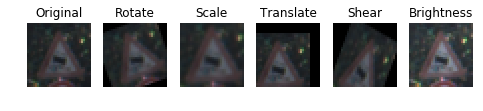

In [6]:
image = X_train[2000, :, :, :]

transform_exmp1 = [image,
                   image_rotate(image, 20),
                   image_scale(image, 1.2),
                   image_translate(image, -5, 5),
                   image_shear(image, 15),
                   image_brightness(image, 1.5)]

transform_title = ['Original', 'Rotate', 'Scale', 'Translate', 'Shear', 'Brightness']
print("")
print('Original and augmented ones\n');
fig, sign = plt.subplots(1, 6, figsize=(8,5))
for i in range(6):
    sign[i].imshow(transform_exmp1[i])
    sign[i].axis('off')
    sign[i].set_title(transform_title[i])

## Here I use these data augmentation techniques on train data:

1. random rotate:        -20 ~ +20 degree
2. random scale:         0.5 ~ 1.5 scale
3. random translate:      -5 ~ +5 pixel
4. random shear:         -20 ~ 20 degree
5. random brightness:     0.5 ~ 2.0 factor

In [7]:
#Transform image according to given parameters
def random_image_transform(image):
    
    randomAngle = random.uniform(-20, 20)
    output = image_rotate(image, randomAngle)
    
    randomScale = random.uniform(0.5, 1.5)
    output = image_scale(output, randomScale)

    randomX = random.uniform(-5, 5)
    randomY = random.uniform(-5, 5)
    output = image_translate(output, randomX, randomY)
    
    randomShear = random.uniform(-20, 20)
    output = image_shear(output, randomShear)
    
    randomFactor = random.uniform(0.5, 2.0)
    output = image_brightness(output, randomFactor)
    
    return output

### To keep the class balance, we generate the image in order to make equal image numbers of each class

In [8]:
#Generate the image in each class with the same number
max_images_per_class=np.max(y_train_dis)+500

import numpy as np

new_train=[]
new_label=[]

while np.sum(y_train_dis) < n_classes * max_images_per_class:
    for index, image in enumerate(X_train):
        img_class = y_train[index]
        
        if y_train_dis[img_class] < max_images_per_class:
            
            new_train.append(random_image_transform(image))
            new_label.append(img_class)
            y_train_dis[img_class] += 1

X_train_n = np.append(X_train, new_train, axis=0)
y_train_n = np.append(y_train, new_label, axis=0)

X_train = X_train_n
y_train = y_train_n

### Apply Center normalizing and converting to grayscale on new trained data
1. Center Normalize: In order to decrease the influence of the big pixel values from images, make the network parameters updating more fast, center normalize image data into [ -1 , 1].
2. Grayscale: in order to reduce input data volume and training time, also because the three diffrent color makes almost no contribution in classification.
3. Equal histogram: in order to normalize image brightness and make contrast enhancement.

In [9]:
#Center normalize
def center_normalize(img):
    
    img = img.astype('float32')
    img = (img - 128)/128
    return img

#Grayscale
def grayscale(image):
    
    imgs = np.ndarray((image.shape[0], 32, 32, 1), dtype=np.uint8)
    for i, img in enumerate(image):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.equalizeHist(img)
        img = np.expand_dims(img, axis=2)
        imgs[i] = img
    
    return imgs

def preprocess(img):
    
    img = grayscale(img)
    img = center_normalize(img)
    return img

In [10]:
# Preprocess the data
X_train_preprocess = preprocess(X_train)
X_valid_preprocess = preprocess(X_valid)
X_test_preprocess = preprocess(X_test)

print("Number of preprocessed training data =", X_train_preprocess.shape[0])
print("Number of preprocessed validation data =", X_valid_preprocess.shape[0])
print("Number of testing data =", X_test_preprocess.shape[0])
print("Train data shape =", X_train_preprocess.shape[1:4])


X_train = X_train_preprocess
X_valid = X_valid_preprocess
X_test = X_test_preprocess

Number of preprocessed training data = 107930
Number of preprocessed validation data = 4410
Number of testing data = 12630
Train data shape = (32, 32, 1)


### Show some traffic sign ones after data augmentation and preprocess

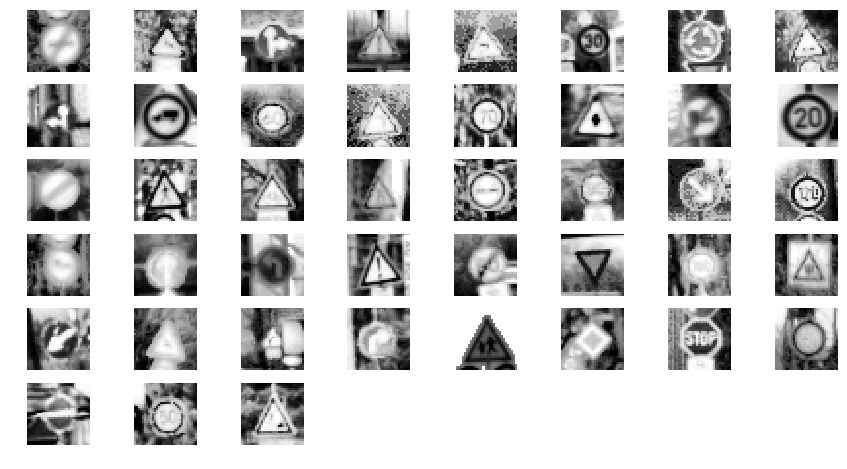

In [11]:
signs = []
caches = []
for index, label in enumerate(y_train):
    if label not in caches:
        caches.append(label)
        signs.append((label, index))

# Show a random collection of the preprocessed images
fig = plt.figure()
fig.set_figwidth(15)
fig.set_figheight(8)

for index, sign in enumerate(signs):
    ax = fig.add_subplot(6, 8, index + 1)
    ax.axis('off')
    image = X_train[sign[1]].squeeze()
    ax.imshow(image, cmap='gray')

----

## Step 2: Design and Test a Model Architecture

### Setup TensorFlow

In [12]:
import tensorflow as tf

EPOCHS = 150
BATCH_SIZE = 256
KEEP_PROB= 0.5

### Model Architecture
1. I choose the modified LeNet network because LeNet network has very good performance in handwriting recognition, so I want to try it in traffic sign classification
2. But the initial LeNet architecture may probably have overfitting problem
3. So I use dropout function on FC2 layer and L2 regularization to avoid the overfitting problem


PS:
    In last Submission,I found in model training step, the predictions are poor on both the training and validation set,it seems model is underfitting so I enhance the complexity of the network by increasing the number of convolution filters, use dropout in two fully connected layers and increase the number of epochs.
    Also I use exponential_decay learing rate function inorder to make good gradient descent direction searching performence.

In [38]:
from tensorflow.contrib.layers import flatten

def LeNetEx(x,keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    #Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x256.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 256), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(256))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    #Activation.
    conv1 = tf.nn.relu(conv1)
    #Pooling. Input = 28x28x256. Output = 14x14x256.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    
    
    #Layer 2: Convolutional. Output = 10x10x100.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 256, 100), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(100))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    #Activation.
    conv2 = tf.nn.relu(conv2)
    #Pooling. Input = 10x10x100. Output = 5x5x100.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    
    #Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    #Layer 3: Fully Connected. Input = 2500. Output = 500.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(25*100, 500), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(500))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    #Activation.
    fc1    = tf.nn.relu(fc1)
    fc1    = tf.nn.dropout(fc1, keep_prob)
    
    #Layer 4: Fully Connected. Input = 500. Output = 100.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(500, 100), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(100))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    #Activation.
    fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(fc2, keep_prob)
    
    #Layer 5: Fully Connected. Input = 100. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(100, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    l2_loss = tf.nn.l2_loss(conv1_W) + tf.nn.l2_loss(conv1_b) + tf.nn.l2_loss(conv2_W) + tf.nn.l2_loss(conv2_b)+tf.nn.l2_loss(fc1_W) + tf.nn.l2_loss(fc1_b)+tf.nn.l2_loss(fc2_W) + tf.nn.l2_loss(fc2_b)+tf.nn.l2_loss(fc3_W) + tf.nn.l2_loss(fc3_b)
    return logits,l2_loss

### Train, Validate and Test the Model

In [39]:
#Placeholders
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)

### Train Pipeline

When trainning  step 0,  l2_loss was not added, train_loss was observed at around 3; 
After adding l2_loss, when trainning step 0, train_loss is around 3500;
So take 0.002 as beta value (have good accuracy rather than 0.001)!

In [40]:
rate = 0.002

logits,l2loss = LeNetEx(x,keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)

##L2 regularization preventing overfitting 
num_examples = len(X_train)

beta = 0.002
loss_operation = tf.reduce_mean(cross_entropy)+beta*l2loss
global_step = tf.Variable(0)
#learning rate set as exponential_decay 
learning_rate = tf.train.exponential_decay(rate,global_step,decay_steps=num_examples/BATCH_SIZE,decay_rate=0.98,staircase=True) 
training_operation = tf.train.AdamOptimizer(learning_rate).minimize(loss_operation,global_step=global_step)

### Model Evaluation

In [41]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        #loss = sess.run(loss_operation, feed_dict={x: batch_x, y: batch_y})
        #print("Evaluate Loss = {:.3f}".format(loss))
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train the Model

In [42]:
from sklearn.utils import shuffle
num_examples = len(X_train)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    print("Training...")
    print()
    step=0
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:KEEP_PROB})
            #loss = sess.run(loss_operation, feed_dict={x: batch_x, y: batch_y,keep_prob:1.0})
            #lr = sess.run(learning_rate)
            #print("Train Loss = {:.3f}".format(loss))
            #print("Learning Rate = {:.3f}".format(lr))
            
            if not step%50:  
                H = sess.run(loss_operation,feed_dict={x: batch_x, y: batch_y,keep_prob:1.0})  
                lr = sess.run(learning_rate)  
                print ("train loss: ",H,"\t","learning_rate: ",lr)  
                if H<1e-1:  #stop early to prevent overfitting  
                    break 
            step +=1;
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        #saver.save(sess, './lenet')
        #print("Model saved")

        if validation_accuracy > 0.985:
            break;
        #test_accuracy = evaluate(X_test, y_test)
        #print("Test Accuracy = {:.3f}".format(test_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

train loss:  13.5539 	 learning_rate:  0.002
train loss:  10.0106 	 learning_rate:  0.002
train loss:  8.89632 	 learning_rate:  0.002
train loss:  7.89725 	 learning_rate:  0.002
train loss:  7.00311 	 learning_rate:  0.002
train loss:  6.21744 	 learning_rate:  0.002
train loss:  5.804 	 learning_rate:  0.002
train loss:  5.04645 	 learning_rate:  0.002
train loss:  4.51948 	 learning_rate:  0.002
EPOCH 1 ...
Validation Accuracy = 0.593

train loss:  4.2337 	 learning_rate:  0.00196
train loss:  3.86028 	 learning_rate:  0.00196
train loss:  3.64511 	 learning_rate:  0.00196
train loss:  3.29598 	 learning_rate:  0.00196
train loss:  2.95643 	 learning_rate:  0.00196
train loss:  2.92934 	 learning_rate:  0.00196
train loss:  2.8119 	 learning_rate:  0.00196
train loss:  2.6243 	 learning_rate:  0.00196
EPOCH 2 ...
Validation Accuracy = 0.835

train loss:  2.4297 	 learning_rate:  0.0019208
train loss:  2.49498 	 learning_rate:  0.0019208
train loss:  2.37308 	 learning_

EPOCH 18 ...
Validation Accuracy = 0.969

train loss:  1.32532 	 learning_rate:  0.00139027
train loss:  1.19076 	 learning_rate:  0.00139027
train loss:  1.17532 	 learning_rate:  0.00139027
train loss:  1.13283 	 learning_rate:  0.00139027
train loss:  1.24245 	 learning_rate:  0.00139027
train loss:  1.12705 	 learning_rate:  0.00139027
train loss:  1.1717 	 learning_rate:  0.00139027
train loss:  1.28091 	 learning_rate:  0.00139027
train loss:  1.25084 	 learning_rate:  0.00139027
EPOCH 19 ...
Validation Accuracy = 0.972

train loss:  1.22529 	 learning_rate:  0.00136247
train loss:  1.15432 	 learning_rate:  0.00136247
train loss:  1.10942 	 learning_rate:  0.00136247
train loss:  1.10585 	 learning_rate:  0.00136247
train loss:  1.21335 	 learning_rate:  0.00136247
train loss:  1.11118 	 learning_rate:  0.00136247
train loss:  1.27917 	 learning_rate:  0.00136247
train loss:  1.15982 	 learning_rate:  0.00136247
EPOCH 20 ...
Validation Accuracy = 0.970

train loss:  1.16489 	 le

train loss:  1.02139 	 learning_rate:  0.00098615
train loss:  1.01431 	 learning_rate:  0.00098615
EPOCH 36 ...
Validation Accuracy = 0.977

train loss:  1.15307 	 learning_rate:  0.000966427
train loss:  0.97423 	 learning_rate:  0.000966427
train loss:  0.973812 	 learning_rate:  0.000966427
train loss:  1.03898 	 learning_rate:  0.000966427
train loss:  0.953355 	 learning_rate:  0.000966427
train loss:  1.08352 	 learning_rate:  0.000966427
train loss:  0.9835 	 learning_rate:  0.000966427
train loss:  1.25228 	 learning_rate:  0.000966427
train loss:  1.1683 	 learning_rate:  0.000947098
EPOCH 37 ...
Validation Accuracy = 0.963

train loss:  1.08487 	 learning_rate:  0.000947098
train loss:  1.06326 	 learning_rate:  0.000947098
train loss:  1.11889 	 learning_rate:  0.000947098
train loss:  0.933099 	 learning_rate:  0.000947098
train loss:  1.02906 	 learning_rate:  0.000947098
train loss:  1.00914 	 learning_rate:  0.000947098
train loss:  1.05476 	 learning_rate:  0.000947098

train loss:  0.880142 	 learning_rate:  0.000685508
train loss:  0.967255 	 learning_rate:  0.000685508
train loss:  0.982602 	 learning_rate:  0.000685508
train loss:  0.914344 	 learning_rate:  0.000685508
train loss:  0.9699 	 learning_rate:  0.000685508
train loss:  0.942782 	 learning_rate:  0.000685508
train loss:  0.967231 	 learning_rate:  0.000685508
train loss:  0.96962 	 learning_rate:  0.000685508
EPOCH 54 ...
Validation Accuracy = 0.982

train loss:  0.939027 	 learning_rate:  0.000671798
train loss:  0.910783 	 learning_rate:  0.000671798
train loss:  0.942219 	 learning_rate:  0.000671798
train loss:  0.943038 	 learning_rate:  0.000671798
train loss:  0.997378 	 learning_rate:  0.000671798
train loss:  0.958714 	 learning_rate:  0.000671798
train loss:  1.05722 	 learning_rate:  0.000671798
train loss:  0.811195 	 learning_rate:  0.000671798
train loss:  1.02413 	 learning_rate:  0.000658362
EPOCH 55 ...
Validation Accuracy = 0.975

train loss:  0.899647 	 learning_rate

train loss:  0.961526 	 learning_rate:  0.000486246
train loss:  0.854983 	 learning_rate:  0.000486246
train loss:  0.957702 	 learning_rate:  0.000486246
train loss:  0.910814 	 learning_rate:  0.000486246
train loss:  0.955541 	 learning_rate:  0.000486246
train loss:  0.908149 	 learning_rate:  0.000476521
EPOCH 71 ...
Validation Accuracy = 0.981

train loss:  0.947487 	 learning_rate:  0.000476521
train loss:  0.897776 	 learning_rate:  0.000476521
train loss:  0.902018 	 learning_rate:  0.000476521
train loss:  1.10975 	 learning_rate:  0.000476521
train loss:  0.944112 	 learning_rate:  0.000476521
train loss:  0.891493 	 learning_rate:  0.000476521
train loss:  1.02797 	 learning_rate:  0.000476521
train loss:  0.948138 	 learning_rate:  0.000476521
EPOCH 72 ...
Validation Accuracy = 0.978

train loss:  0.922621 	 learning_rate:  0.000466991
train loss:  0.89226 	 learning_rate:  0.000466991
train loss:  0.899949 	 learning_rate:  0.000466991
train loss:  1.02252 	 learning_rat

train loss:  0.858574 	 learning_rate:  0.000344905
train loss:  0.960658 	 learning_rate:  0.000344905
train loss:  0.935865 	 learning_rate:  0.000344905
train loss:  0.871545 	 learning_rate:  0.000338007
EPOCH 88 ...
Validation Accuracy = 0.978

train loss:  0.797968 	 learning_rate:  0.000338007
train loss:  0.856127 	 learning_rate:  0.000338007
train loss:  0.872828 	 learning_rate:  0.000338007
train loss:  0.924081 	 learning_rate:  0.000338007
train loss:  0.868154 	 learning_rate:  0.000338007
train loss:  0.914465 	 learning_rate:  0.000338007
train loss:  0.915844 	 learning_rate:  0.000338007
train loss:  0.896904 	 learning_rate:  0.000338007
train loss:  0.88585 	 learning_rate:  0.000331247
EPOCH 89 ...
Validation Accuracy = 0.978

train loss:  0.922314 	 learning_rate:  0.000331247
train loss:  0.860134 	 learning_rate:  0.000331247
train loss:  1.00128 	 learning_rate:  0.000331247
train loss:  0.832817 	 learning_rate:  0.000331247
train loss:  0.969621 	 learning_r

train loss:  0.951533 	 learning_rate:  0.000244649
train loss:  0.849713 	 learning_rate:  0.000244649
train loss:  0.82533 	 learning_rate:  0.000239756
EPOCH 105 ...
Validation Accuracy = 0.977

train loss:  1.02478 	 learning_rate:  0.000239756
train loss:  0.941695 	 learning_rate:  0.000239756
train loss:  0.955929 	 learning_rate:  0.000239756
train loss:  0.888426 	 learning_rate:  0.000239756
train loss:  0.882203 	 learning_rate:  0.000239756
train loss:  1.0202 	 learning_rate:  0.000239756
train loss:  0.801248 	 learning_rate:  0.000239756
train loss:  0.881811 	 learning_rate:  0.000234961
EPOCH 106 ...
Validation Accuracy = 0.979

train loss:  0.930539 	 learning_rate:  0.000234961
train loss:  0.776676 	 learning_rate:  0.000234961
train loss:  0.821761 	 learning_rate:  0.000234961
train loss:  0.869062 	 learning_rate:  0.000234961
train loss:  0.819951 	 learning_rate:  0.000234961
train loss:  1.00519 	 learning_rate:  0.000234961
train loss:  0.885033 	 learning_ra

train loss:  0.837403 	 learning_rate:  0.000170064
EPOCH 122 ...
Validation Accuracy = 0.979

train loss:  0.861667 	 learning_rate:  0.000170064
train loss:  0.905919 	 learning_rate:  0.000170064
train loss:  0.844616 	 learning_rate:  0.000170064
train loss:  0.879252 	 learning_rate:  0.000170064
train loss:  0.873329 	 learning_rate:  0.000170064
train loss:  0.933126 	 learning_rate:  0.000170064
train loss:  0.815987 	 learning_rate:  0.000170064
train loss:  1.06484 	 learning_rate:  0.000170064
train loss:  0.872623 	 learning_rate:  0.000166663
EPOCH 123 ...
Validation Accuracy = 0.978

train loss:  0.853373 	 learning_rate:  0.000166663
train loss:  0.914076 	 learning_rate:  0.000166663
train loss:  0.820305 	 learning_rate:  0.000166663
train loss:  0.943862 	 learning_rate:  0.000166663
train loss:  0.97188 	 learning_rate:  0.000166663
train loss:  0.808792 	 learning_rate:  0.000166663
train loss:  0.856468 	 learning_rate:  0.000166663
train loss:  0.851814 	 learning

EPOCH 139 ...
Validation Accuracy = 0.976

train loss:  0.868693 	 learning_rate:  0.00012063
train loss:  0.918457 	 learning_rate:  0.00012063
train loss:  0.857138 	 learning_rate:  0.00012063
train loss:  0.838252 	 learning_rate:  0.00012063
train loss:  0.865143 	 learning_rate:  0.00012063
train loss:  0.726189 	 learning_rate:  0.00012063
train loss:  0.854667 	 learning_rate:  0.00012063
train loss:  0.948121 	 learning_rate:  0.000118218
EPOCH 140 ...
Validation Accuracy = 0.979

train loss:  0.807856 	 learning_rate:  0.000118218
train loss:  0.861032 	 learning_rate:  0.000118218
train loss:  0.864211 	 learning_rate:  0.000118218
train loss:  0.862068 	 learning_rate:  0.000118218
train loss:  0.862292 	 learning_rate:  0.000118218
train loss:  0.860769 	 learning_rate:  0.000118218
train loss:  0.951717 	 learning_rate:  0.000118218
train loss:  0.83483 	 learning_rate:  0.000115853
train loss:  0.89349 	 learning_rate:  0.000115853
EPOCH 141 ...
Validation Accuracy = 0.9

### Evaluate the Model

In [43]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from .\lenet
Test Accuracy = 0.947


## Step 3: Test a Model on New Images


### Load and Output the Images

#### Here is ten new German Traffic signs found on the web,and the images are visualized
The brightness and contrast of the ten collected images are pretty good which may help the accuracy of prediction.
But image fonud on the web may not have good point of view ,for example the priority road sign in train dataset looks great but which one found on the web has been misclassified by trained model as "Yield (31.62%)" in following prediction result may due to the reason of rotation in image.

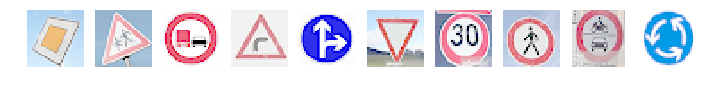

In [49]:
import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
from skimage import data, exposure, img_as_float
from PIL import ImageEnhance  

%matplotlib inline

import tensorflow as tf

from pandas.io.parsers import read_csv

ImagePath = './test/*.png'
test_images = []

for index, img in enumerate(glob.glob(ImagePath)):
    image = cv2.imread(img)
    image = cv2.resize(image, (32, 32))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image= exposure.adjust_gamma(image, 0.4) 
    image= exposure.adjust_log(image)
    test_images.append(image)

# Show original test images
figure = plt.figure()
figure.set_figwidth(12)
figure.set_figheight(6)

for index, image in enumerate(test_images):
    t = figure.add_subplot(1, 10, index + 1)
    t.axis('off')
    t.imshow(image)

#### Use previous pipeline to preprocess new test images

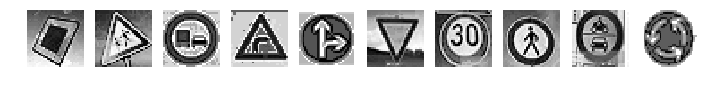

In [50]:
X_test_new = np.array(test_images)
X_test_new = preprocess(X_test_new)

# Show preprocessed test images
figure = plt.figure()
figure.set_figwidth(12)
figure.set_figheight(6)

for index, image in enumerate(X_test_new):
    t = figure.add_subplot(1, 10, index + 1)
    t.axis('off')
    image = X_test_new[index].squeeze()
    t.imshow(image, cmap='gray')

### Predict the Sign Type for Each Image

#### Run the predictions here and use the model to output the prediction for each image.
#### Make sure to pre-process the images with the same pre-processing pipeline used earlier.

In [51]:
signnames = read_csv("signnames.csv").values[:, 1]
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('./lenet.meta')
    saver.restore(sess, save_path='./lenet')
    
    # Calculate the top 5
    softmax_logits = tf.nn.softmax(logits)
    top_5 = tf.nn.top_k(softmax_logits, k=5)
    top_5_pred = sess.run(top_5, feed_dict={x: X_test_new, keep_prob: 1.0})
    
    predict_values = top_5_pred.values
    predict_indices = top_5_pred.indices
    
    for i, image in enumerate(X_test_new):
        predict = predict_values[i][0]
        signname = signnames[predict_indices[i][0].astype(int)]
        # print the sign name and its probability
        print('{} ({:.2f}%)'.format(signname, 100*predict))

INFO:tensorflow:Restoring parameters from ./lenet
Yield (31.62%)
Children crossing (46.34%)
Vehicles over 3.5 metric tons prohibited (58.78%)
Dangerous curve to the right (94.43%)
Go straight or right (56.67%)
Yield (100.00%)
Speed limit (30km/h) (98.97%)
General caution (46.41%)
Speed limit (20km/h) (36.15%)
Speed limit (20km/h) (82.59%)


### Analyze Performance

#### Calculate the accuracy for these 10 new images. 

In [2]:
new_img_predict_accuracy = 5/10
print('Prediction accuracy on new images: ', new_img_predict_accuracy*100, '%')

Prediction accuracy on new images:  50.0 %


#### Compare the prediction accuracy of collected traffic signs from WEB and of the test dataset

In [ ]:
The accuracy on the captured images from web is 50% while it was 94.7% on the testing set thus It seems the model 
is overfitting on the training dataset or 43 classes of traffic signs here in train dataset do not cover all traffice sign classes in German.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

### Discussion
The model is very certain on 1th、3th、4th、5th、6th images' prediction result; 
But the other images' prediction results are uncertain.


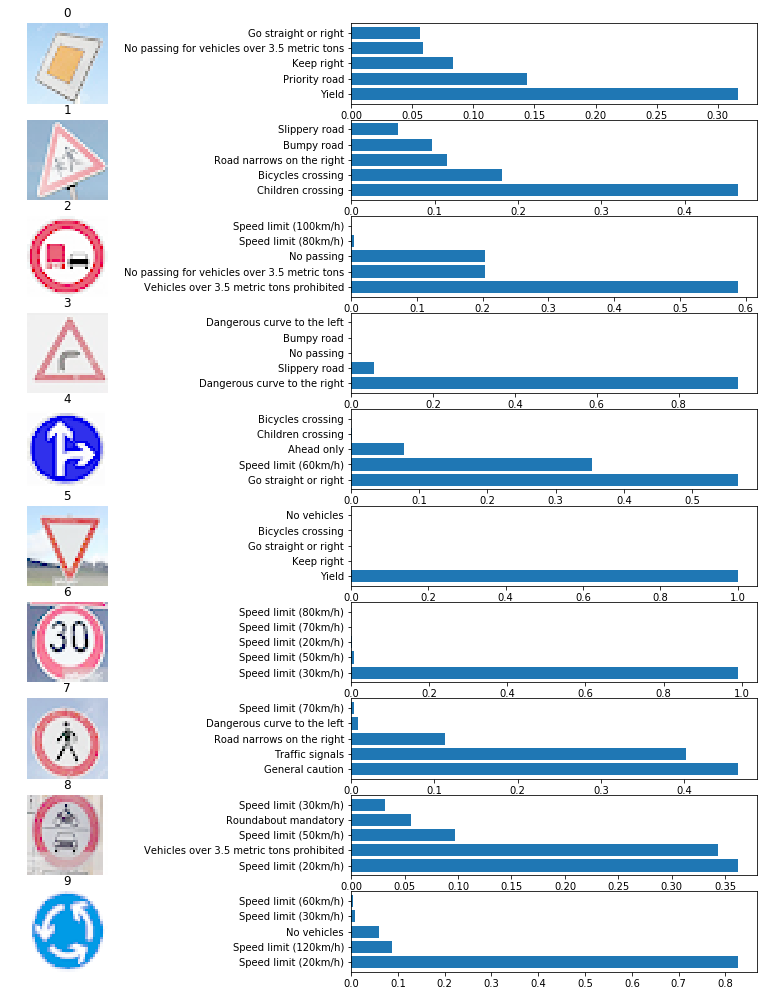

In [52]:
# Top 5 softmax possibilities have been calculated above, now the output is visualized here. 
plt.figure(figsize=(16, 21))
for i in range(len(X_test_new)):
    plt.subplot(12, 2, 2*i+1)
    plt.imshow(test_images[i]) 
    plt.title(i)
    plt.axis('off')
    plt.subplot(12, 2, 2*i+2)
    plt.barh(np.arange(1, 6, 1), predict_values[i, :])
    labs=[signnames[j] for j in predict_indices[i]]
    plt.yticks(np.arange(1, 6, 1), labs)
plt.show()